Hard Section Center: 7.125
=== Agilus Fourier Series ===
0.6722222222 -0.0243504112 * cos(1*pi ((x^2 + y^2)^0.5)/15) +0.2444856975 * cos(2*pi ((x^2 + y^2)^0.5)/15) +0.0445210612 * cos(3*pi ((x^2 + y^2)^0.5)/15) -0.1208307676 * cos(4*pi ((x^2 + y^2)^0.5)/15) -0.0255098897 * cos(5*pi ((x^2 + y^2)^0.5)/15) +0.0228607939 * cos(6*pi ((x^2 + y^2)^0.5)/15) -0.0019441999 * cos(7*pi ((x^2 + y^2)^0.5)/15) +0.0164878106 * cos(8*pi ((x^2 + y^2)^0.5)/15) +0.0143090285 * cos(9*pi ((x^2 + y^2)^0.5)/15) -0.0118764340 * cos(10*pi ((x^2 + y^2)^0.5)/15) -0.0057564254 * cos(11*pi ((x^2 + y^2)^0.5)/15) -0.0012412520 * cos(12*pi ((x^2 + y^2)^0.5)/15) -0.0065046629 * cos(13*pi ((x^2 + y^2)^0.5)/15) +0.0042719569 * cos(14*pi ((x^2 + y^2)^0.5)/15) +0.0066998077 * cos(15*pi ((x^2 + y^2)^0.5)/15) -0.0008505001 * cos(16*pi ((x^2 + y^2)^0.5)/15) +0.0014185709 * cos(17*pi ((x^2 + y^2)^0.5)/15) -0.0007635188 * cos(18*pi ((x^2 + y^2)^0.5)/15) -0.0051057551 * cos(19*pi ((x^2 + y^2)^0.5)/15) -0.0000108156 * cos(20*pi (

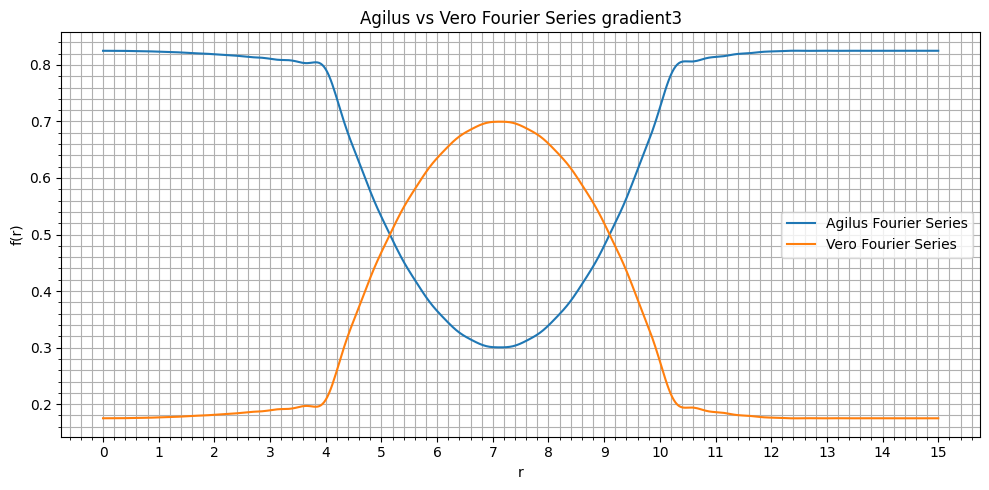

Wrote: C:\Program Files\VCAD_Studio_Windows_2.2.0\studio\MAC_LAB\SingleStack\fourier_SingleStack_gradient3_N60_stiff30-70_soft80-20_grad82.5-80_.py


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import sympy as sp
from sympy import symbols, Piecewise, And, Or
import math
import inspect
import os

# === GRADIENT SETTINGS ===
use_radial = False   # True for radial plots, False for regular plots
L = 15               # Plot Settings
N = 60               # number of Fourier modes (solid quality at 85)
agilus_stiff_section = 30  # percentage of agilus in the stiff portion of the bellows
vero_stiff_section = 100 - agilus_stiff_section
agilus_soft_section = 80   # percentage of agilus in the soft portion of the bellows
vero_soft_section = 100 - agilus_soft_section

# Stiff and soft sections must add up to 100% in each section
gradient_start = agilus_soft_section +2.5       # Start of the gradient section (Agilus percentage)
gradient_end = agilus_soft_section
gradient4_vero = 50      # Percentage of vero in the middle cap of the bellows
gradient4_agilus = 100 - gradient4_vero

# === Choose one gradient type ===
gradient1 = False   # Gradient for constant soft sections
gradient2 = False  # Gradient for linear soft sections
gradient3 = True  # Gradient for parabolic soft sections
gradient4 = False  # Gradient for some vero in the middle cap of the bellows

# === Design Settings ===
stack = True
dual_wb = False
dual_nb = False

# === Software Settings ===
generateFile = True

# === Geometry Settings ===
mainDiameter = 25  # diameter of each bellows
pipeDiameter = 3.5  # inner diameter of bellow opening
edgeThickness = 2.25  # thickness of inner and outter sections of each bellows

# Gradient 4 Only:
linearStart_Gr4 = 4.5
linearEnd_Gr4 = 4.75


# ----------------------------------------------------------------------------------

if sum([gradient1, gradient2, gradient3, gradient4]) != 1:
    raise ValueError(
        "Exactly one of gradient1, gradient2, gradient3, gradient4 must be True.")
if sum([stack, dual_wb, dual_nb]) != 1:
    raise ValueError(
        "Exactly one of stack_wb, stack_nb, dual_wb, dual_nb must be True.")

if L < mainDiameter/2:
    raise ValueError(
        "Integration end point (L) must be larger then bellows radius."
    )

# Determine which gradient type string to inject
if gradient1:
    gradient_type = "gradient1"
elif gradient2:
    gradient_type = "gradient2"
elif gradient3:
    gradient_type = "gradient3"
else:
    gradient_type = "gradient4"

if stack:
    design = "Single stack"
    design_filename = "SingleStack"
elif dual_wb:
    design = "Dual assembly with baffles"
    design_filename = "DualStackWB"
else:
    design = "Dual assembly without baffles"
    design_filename = "DualStackNB"


# === DEFINE SYMBOLIC PIECEWISE FUNCTIONS ===

def gradient_calculator(agilus_stiff, vero_stiff, agilus_soft, vero_soft,
                        gradient_start, gradient_end, gradient4_vero, gradient4_agilus):
    agilus_stiff = agilus_stiff / 100.0
    vero_stiff = vero_stiff / 100.0
    agilus_soft = agilus_soft / 100.0
    vero_soft = vero_soft / 100.0
    gradient_start = gradient_start / 100.0
    gradient_end = gradient_end / 100.0
    gradient4_vero = gradient4_vero / 100.0
    gradient4_agilus = gradient4_agilus / 100.0
    hardSectionCenter = pipeDiameter/2 + edgeThickness + \
        (mainDiameter/2 - pipeDiameter/2 - 2*edgeThickness)/2
    agilus_coefficient1 = (agilus_soft - agilus_stiff) / (((hardSectionCenter) - (
        # inside purple parenthesis was originally -2.75
        pipeDiameter/2 + edgeThickness)) ** 2)
    # agilus_coefficient1 = (agilus_soft - agilus_stiff) / (((pipeDiameter/2) + edgeThickness - 0.875) ** 2) #inside purple parenthesis was originally -2.75
    vero_coefficient = -agilus_coefficient1

    def piecewise_function_gradient(agilus_coefficient1, vero_coefficient):
        x = symbols('x')
        # hardSectionCenter = pipeDiameter/2 + edgeThickness + (mainDiameter/2-pipeDiameter/2-2*edgeThickness)/2
        print("Hard Section Center: " + str(hardSectionCenter))

        # Constant gradient for soft sections
        if gradient1:
            agilus_piecewise = Piecewise(
                (agilus_soft, Or(And(x >= -mainDiameter/2, x <= -mainDiameter/2+edgeThickness),
                                 And(x >= -pipeDiameter/2-edgeThickness,
                                     x <= pipeDiameter/2-edgeThickness),
                                 And(x >= mainDiameter/2-edgeThickness,     x <= mainDiameter/2))),
                (agilus_coefficient1 * (x + hardSectionCenter) ** 2 + agilus_stiff,
                 And(x > -mainDiameter/2+edgeThickness, x < -pipeDiameter/2-edgeThickness)),
                (agilus_coefficient1 * (x - hardSectionCenter) ** 2 + agilus_stiff,
                 And(x > pipeDiameter/2+edgeThickness,  x < mainDiameter/2-edgeThickness)),
                (agilus_soft, True)
            )

            vero_piecewise = Piecewise(
                (vero_soft, Or(And(x >= -mainDiameter/2, x <= -mainDiameter/2+edgeThickness),
                               And(x >= -pipeDiameter/2-edgeThickness,
                                   x <= pipeDiameter/2-edgeThickness),
                               And(x >= mainDiameter/2-edgeThickness,     x <= mainDiameter/2))),
                (vero_coefficient * (x + hardSectionCenter) ** 2 + vero_stiff,
                 And(x > -mainDiameter/2+edgeThickness, x < -pipeDiameter/2-edgeThickness)),
                (vero_coefficient * (x - hardSectionCenter) ** 2 + vero_stiff,
                 And(x > pipeDiameter/2+edgeThickness,  x < mainDiameter/2-edgeThickness)),
                (vero_soft, True)
            )
            return agilus_piecewise, vero_piecewise

        # Linear Gradient for soft sections
        elif gradient2:
            linear_slope1 = (gradient_start - gradient_end) / (edgeThickness)
            constant_intercept1 = gradient_start - \
                (linear_slope1 * -mainDiameter/2)
            linear_slope2 = (gradient_end - gradient_start) / \
                (pipeDiameter/2+edgeThickness)
            """
            linear_slope1 = (gradient_start - gradient_end) / (-12.5 + 10)
            constant_intercept1 = gradient_start - (linear_slope1 * -12.5)
            linear_slope2 = (gradient_end - gradient_start) / 4.5"""

            agilus_piecewise = Piecewise(
                (linear_slope1 * x + constant_intercept1,
                 And(x >= -mainDiameter/2, x <= -mainDiameter/2+edgeThickness)),
                (-linear_slope1 * x + constant_intercept1,
                 And(x >= mainDiameter/2-edgeThickness, x <= mainDiameter/2)),
                (1 + linear_slope2 * sp.Abs(x),
                 And(x >= -edgeThickness-pipeDiameter/2, x <= edgeThickness+pipeDiameter/2)),
                (agilus_coefficient1 * (x + hardSectionCenter) ** 2 + agilus_stiff,
                 And(x > -mainDiameter/2+edgeThickness, x < -edgeThickness-pipeDiameter/2)),
                (agilus_coefficient1 * (x - hardSectionCenter) ** 2 + agilus_stiff,
                 And(x > pipeDiameter/2 + edgeThickness, x < mainDiameter/2 - edgeThickness)),
                (gradient_start, True)
            )

            vero_piecewise = Piecewise(
                (-linear_slope1 * x + (1 - constant_intercept1),
                 And(x >= -mainDiameter/2, x <= -mainDiameter/2+edgeThickness)),
                (linear_slope1 * x + (1 - constant_intercept1),
                 And(x >= mainDiameter/2-edgeThickness, x <= mainDiameter/2)),
                (-linear_slope2 * sp.Abs(x),
                 And(x >= -edgeThickness-pipeDiameter/2, x <= edgeThickness+pipeDiameter/2)),
                (vero_coefficient * (x + hardSectionCenter) ** 2 + vero_stiff,
                 And(x > -mainDiameter/2+edgeThickness, x < -edgeThickness-pipeDiameter/2)),
                (vero_coefficient * (x - hardSectionCenter) ** 2 + vero_stiff,
                 And(x > pipeDiameter/2 + edgeThickness, x < mainDiameter/2 - edgeThickness)),
                (1 - gradient_start, True)
            )
            return agilus_piecewise, vero_piecewise

        # Parabolic Gradient for soft sections
        elif gradient3:
            parabolic_slope1 = - \
                (gradient_end - gradient_start) / ((edgeThickness) ** 2)
            parabolic_slope2 = -(gradient_end - gradient_start) / \
                (((pipeDiameter/2) + (edgeThickness)) ** 2)

            agilus_piecewise = Piecewise(
                (-parabolic_slope1 * (x + mainDiameter/2) ** 2 + gradient_start,
                 And(x >= -mainDiameter/2, x <= -(mainDiameter/2) + (edgeThickness))),
                (-parabolic_slope1 * (x - mainDiameter/2) ** 2 + gradient_start,
                 And(x >= (mainDiameter/2) - edgeThickness, x <= mainDiameter / 2)),
                (-parabolic_slope2 * x ** 2 + gradient_start,
                 And(x >= -(pipeDiameter/2) - edgeThickness, x <= (pipeDiameter / 2) + edgeThickness)),
                (agilus_coefficient1 * (x + hardSectionCenter) ** 2 + agilus_stiff,
                 And(x > -(mainDiameter/2) + edgeThickness, x < -edgeThickness - (pipeDiameter/2))),
                (agilus_coefficient1 * (x - hardSectionCenter) ** 2 + agilus_stiff,
                 And(x > edgeThickness + (pipeDiameter/2), x < (mainDiameter/2) - edgeThickness)),
                (gradient_start, True)
            )

            vero_piecewise = Piecewise(
                (parabolic_slope1 * (x + mainDiameter/2) ** 2 + (1 - gradient_start),
                 And(x >= -mainDiameter/2, x <= -(mainDiameter/2) + edgeThickness)),
                (parabolic_slope1 * (x - mainDiameter/2) ** 2 + (1 - gradient_start),
                 And(x >= (mainDiameter/2) - edgeThickness, x <= mainDiameter/2)),
                (parabolic_slope2 * x ** 2 + (1 - gradient_start),
                 And(x >= -edgeThickness - (pipeDiameter/2), x <= edgeThickness + (pipeDiameter/2))),
                (vero_coefficient * (x + hardSectionCenter) ** 2 + vero_stiff,
                 And(x > -mainDiameter/2 + edgeThickness, x < -(pipeDiameter/2) - edgeThickness)),
                (vero_coefficient * (x - hardSectionCenter) ** 2 + vero_stiff,
                 And(x > (pipeDiameter/2) + edgeThickness, x < (mainDiameter/2) - edgeThickness)),
                (1 - gradient_start, True)
            )
            return agilus_piecewise, vero_piecewise

        # Gradient4 Variation
        elif gradient4:

            parabolic_slope1 = - \
                (gradient_end - gradient_start) / ((edgeThickness) ** 2)
            parabolic_slope3 = -((gradient_end) - gradient4_vero) / (2 ** 2)

            parabolic_Center = (pipeDiameter/2+edgeThickness+linearStart_Gr4)/2
            print(parabolic_Center)

            agilus_piecewise = Piecewise(
                (-parabolic_slope1 * (x + mainDiameter/2) ** 2 + gradient_start,
                 And(x >= -mainDiameter/2, x <= -mainDiameter/2+edgeThickness)),
                (-parabolic_slope1 * (x - mainDiameter/2) ** 2 + gradient_start,
                 And(x >= mainDiameter/2-edgeThickness, x <= mainDiameter/2)),
                (-parabolic_slope3 * ((x + parabolic_Center) ** 2) + gradient4_agilus,
                 And(x >= -linearStart_Gr4, x <= -pipeDiameter/2-edgeThickness)),
                (-parabolic_slope3 * ((x - parabolic_Center) ** 2) + gradient4_agilus,
                 And(x >= pipeDiameter/2+edgeThickness, x <= linearStart_Gr4)),
                (agilus_coefficient1 * (x + hardSectionCenter) ** 2 + agilus_stiff,
                 And(x > -mainDiameter/2+edgeThickness, x < -linearEnd_Gr4)),
                (agilus_coefficient1 * (x - hardSectionCenter) ** 2 + agilus_stiff,
                 And(x > linearEnd_Gr4, x < mainDiameter/2-edgeThickness)),
                (gradient_start, True)
            )

            vero_piecewise = Piecewise(
                (parabolic_slope1 * (x + mainDiameter/2) ** 2 + (1 - gradient_start),
                 And(x >= -mainDiameter/2, x <= -mainDiameter/2+edgeThickness)),
                (parabolic_slope1 * (x - mainDiameter/2) ** 2 + (1 - gradient_start),
                 And(x >= mainDiameter/2-edgeThickness, x <= mainDiameter/2)),
                (parabolic_slope3 * ((x + parabolic_Center) ** 2) + gradient4_vero,
                 And(x >= -linearStart_Gr4, x <= -pipeDiameter/2-edgeThickness)),
                (parabolic_slope3 * ((x - parabolic_Center) ** 2) + gradient4_vero,
                 And(x >= pipeDiameter/2+edgeThickness, x <= linearStart_Gr4)),
                (vero_coefficient * (x + hardSectionCenter) ** 2 + vero_stiff,
                 And(x > -mainDiameter/2+edgeThickness, x < -linearEnd_Gr4)),
                (vero_coefficient * (x - hardSectionCenter) ** 2 + vero_stiff,
                 And(x > linearEnd_Gr4, x < mainDiameter/2-edgeThickness)),
                (1 - gradient_start, True)
            )
            return agilus_piecewise, vero_piecewise

        else:
            raise ValueError(
                "No valid gradient type selected. "
                "Please set one of gradient1, gradient2, gradient3, or gradient4 to True."
            )

    agilus_piecewise, vero_piecewise = piecewise_function_gradient(
        agilus_coefficient1, vero_coefficient
    )
    return agilus_piecewise, vero_piecewise


# === BUILD NUMERIC FUNCTIONS FROM SYMBOLIC EXPRESSIONS ===
agilus_piecewise_sym, vero_piecewise_sym = gradient_calculator(
    agilus_stiff_section,
    vero_stiff_section,
    agilus_soft_section,
    vero_soft_section,
    gradient_start,
    gradient_end,
    gradient4_vero,
    gradient4_agilus
)
x = symbols('x')
f_1D = sp.lambdify(x, agilus_piecewise_sym, 'math')
f_1D_opp = sp.lambdify(x, vero_piecewise_sym, 'math')


def radial_piecewise_function(r):
    return f_1D(abs(r))


def opposite_radial_piecewise_function(r):
    return f_1D_opp(abs(r))


# === MANUAL SEGMENTS FOR INTEGRATION ===
if gradient4:
    segments = [
        (-L, -mainDiameter/2),
        (-mainDiameter/2, -mainDiameter/2+edgeThickness),
        (-mainDiameter/2+edgeThickness, -linearEnd_Gr4),
        (-linearEnd_Gr4, -linearStart_Gr4),
        (-linearStart_Gr4, -pipeDiameter/2-edgeThickness),
        (-pipeDiameter/2-edgeThickness, pipeDiameter/2+edgeThickness),
        (pipeDiameter/2+edgeThickness, linearStart_Gr4),
        (linearStart_Gr4, linearEnd_Gr4),
        (linearEnd_Gr4, mainDiameter/2-edgeThickness),
        (mainDiameter/2-edgeThickness, mainDiameter/2),
        (mainDiameter/2, L)
    ]
else:
    segments = [
        (-L, -mainDiameter/2),
        (-mainDiameter/2, -mainDiameter/2 + edgeThickness),
        (-mainDiameter/2 + edgeThickness, -edgeThickness),
        (-edgeThickness, edgeThickness),
        (edgeThickness, mainDiameter/2 - edgeThickness),
        (mainDiameter/2 - edgeThickness, mainDiameter/2),
        (mainDiameter/2, L)
    ]


def integrate_piecewise(expr, L, n=0, kind=None):
    total = 0.0
    for a, b in segments:
        def integrand(x_val):
            val = expr(x_val)
            if kind == 'cos':
                val *= math.cos(n * math.pi * x_val / L)
            elif kind == 'sin':
                val *= math.sin(n * math.pi * x_val / L)
            return val
        total += quad(integrand, a, b, limit=100)[0]
    return (1.0 / L) * total


def compute_fourier_coeffs(f, L, N):
    a0 = integrate_piecewise(f, L)
    an, bn = [], []
    for k in range(1, N + 1):
        an.append(integrate_piecewise(f, L, k, 'cos'))
        bn.append(integrate_piecewise(f, L, k, 'sin'))
    return a0, an, bn


# === FOURIER SERIES EVALUATION ===
def fourier_series(x_val, L, a0, an, bn):
    s = a0 / 2.0
    for k in range(1, len(an) + 1):
        s += an[k - 1] * math.cos(k * math.pi * x_val / L) \
            + bn[k - 1] * math.sin(k * math.pi * x_val / L)
    return s


def fourier_series_string_3D(L, a0, an, bn):
    terms = [f"{a0/2:.10f}"]
    for k in range(1, len(an) + 1):
        a, b = an[k - 1], bn[k - 1]
        if abs(a) > 1e-6:
            terms.append(f"{a:+.10f} * cos({k}*pi ((x^2 + y^2)^0.5)/{L})")
        if abs(b) > 1e-6:
            terms.append(f"{b:+.10f} * sin({k}*pi ((x^2 + y^2)^0.5)/{L})")
    return " ".join(terms)

# === TEMPLATE‐BASED FILE GENERATION ===


def write_py_from_template(template_path, output_path, function_objects, settings):
    """
    Reads a template file, replaces {{functions}} with the source code of
    the given function objects, and substitutes {{key}} placeholders
    with corresponding values from settings.
    """
    # Read template
    with open(template_path, 'r', encoding='utf-8') as f:
        content = f.read()

    # Extract source for each function and join
    func_src_list = [inspect.getsource(fobj) for fobj in function_objects]
    functions_block = "\n\n".join(func_src_list)
    content = content.replace("{{functions}}", functions_block)

    # Replace each {{key}} with the stringified value
    for key, val in settings.items():
        placeholder = "{{" + key + "}}"
        content = content.replace(placeholder, str(val))

    # Write the generated file
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(content)


# === TEMPLATE-BASED FILE GENERATION ===

def make_filename_from_settings(base_dir, settings):
    """
    Constructs a .py filename that encodes key settings, e.g.:
    fourier_L15_N80_stiff45-55_soft90-10_gradStart95-gradEnd90.py
    """
    L = settings["L"]
    N = settings["N"]
    a_st = settings["agilus_stiff_section"]
    v_st = settings["vero_stiff_section"]
    a_so = settings["agilus_soft_section"]
    v_so = settings["vero_soft_section"]
    g_s = settings["gradient_start"]
    g_e = settings["gradient_end"]
    g4v = settings["gradient4_vero"]
    g4a = settings["gradient4_agilus"]

    name = (
        f"fourier_"
        f"{design_filename}_"
        f"{gradient_type}_"
        f"N{N}_"
        f"stiff{a_st}-{v_st}_"
        f"soft{a_so}-{v_so}_"
        f"grad{g_s}-{g_e}_.py"
    )
    return base_dir.rstrip("\\/") + "\\" + name  # Windows path


# === MAIN SCRIPT ===
if use_radial:
    f = radial_piecewise_function
    f_opp = opposite_radial_piecewise_function
else:
    f = f_1D
    f_opp = f_1D_opp

a0, an, bn = compute_fourier_coeffs(f, L, N)
a0_opp, an_opp, bn_opp = compute_fourier_coeffs(f_opp, L, N)

print("=== Agilus Fourier Series ===")
agilus_string = fourier_series_string_3D(L, a0, an, bn)
print(agilus_string)

print("\n=== Vero Fourier Series ===")
vero_string = fourier_series_string_3D(L, a0_opp, an_opp, bn_opp)
print(vero_string)

# === PLOTTING ===
if use_radial:
    x_vals = np.linspace(-L, L, 300)
    y_vals = np.linspace(-L, L, 300)
    X, Y = np.meshgrid(x_vals, y_vals)
    R = np.sqrt(X ** 2 + Y ** 2)

    Z_f = np.vectorize(lambda r: fourier_series(r, L, a0, an, bn))(R)
    Z_opp = np.vectorize(lambda r: fourier_series(
        r, L, a0_opp, an_opp, bn_opp))(R)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    c1 = ax1.pcolormesh(X, Y, Z_f, shading='auto')
    c2 = ax2.pcolormesh(X, Y, Z_opp, shading='auto')

    fig.colorbar(c1, ax=ax1)
    fig.colorbar(c2, ax=ax2)
    ax1.set_title("Radial Agilus Fourier Series")
    ax2.set_title("Radial Vero Fourier Series")
    for ax in (ax1, ax2):
        ax.set_xlabel("r")
        ax.set_ylabel("y")
        ax.axis('equal')

    plt.tight_layout()
    plt.show()

else:
    x_vals = np.linspace(0, L, 500)
    y_f = [fourier_series(xi, L, a0, an, bn) for xi in x_vals]
    y_opp = [fourier_series(xi, L, a0_opp, an_opp, bn_opp) for xi in x_vals]

    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, y_f,   label="Agilus Fourier Series")
    plt.plot(x_vals, y_opp, label="Vero Fourier Series")
    plt.title("Agilus vs Vero Fourier Series " + gradient_type)
    plt.minorticks_on()
    plt.xticks(np.arange(0, L + 1))
    plt.xlabel("r")
    plt.ylabel("f(r)")
    plt.grid(which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()

# === TEMPLATE-BASED FILE GENERATION ===
# Mass comment this section to skip file generation
if generateFile == True:

    # 1) Define where to put generated files:
    if stack:
        base_output_folder = r"C:\Program Files\VCAD_Studio_Windows_2.2.0\studio\MAC_LAB\SingleStack"
    elif dual_wb:
        base_output_folder = r"C:\Program Files\VCAD_Studio_Windows_2.2.0\studio\MAC_LAB\DoubleStack_WB"
    else:
        base_output_folder = r"C:\Program Files\VCAD_Studio_Windows_2.2.0\studio\MAC_LAB\DoubleStack_NB"


    # 2) Build our settings dict as before:
    settings = {
        "use_radial":          use_radial,
        "L":                   L,
        "N":                   N,
        "agilus_stiff_section": agilus_stiff_section,
        "vero_stiff_section":   vero_stiff_section,
        "agilus_soft_section":  agilus_soft_section,
        "vero_soft_section":    vero_soft_section,
        "gradient_start":      gradient_start,
        "gradient_end":        gradient_end,
        "gradient4_vero":      gradient4_vero,
        "gradient4_agilus":    gradient4_agilus,
        "gradient_type":       gradient_type,
        "agilus_string":       agilus_string,
        "vero_string":         vero_string,
        "design":              design,
        "design_filename":     design_filename
    }

    # 3) List of functions to inject:
    functions_to_inject = [fourier_series, fourier_series_string_3D]

    # 4) Compute the actual output_path at runtime:
    output_path = make_filename_from_settings(base_output_folder, settings)

    # 5) Call the generator:
    if stack:
        template_path = r"C:\Users\andre\OneDrive\Documents\Python\MAC LAB\File_Generator\FourierGenerator_v2.1\Templates\VariableSingleStack_template.py"
    elif dual_wb:
        template_path = r"C:\Users\andre\OneDrive\Documents\Python\MAC LAB\File_Generator\FourierGenerator_v2.1\Templates\Variable_Dual_Stack_w_Baffles_TEST.py"
    else:
        template_path = r"C:\Users\andre\OneDrive\Documents\Python\MAC LAB\File_Generator\FourierGenerator_v2.1\Templates\DualStackNB_template.py"

    write_py_from_template(template_path, output_path,
                           functions_to_inject, settings)

    print("Wrote:", output_path)

else:
    print("No File Written")